# AI Tools for Actuaries
## Chapter 5: FNN entity embedding
### Authors: Marco Maggi, Michael Mayer and Mario Wuthrich
### Version May, 2025

In [1]:
import numpy as np
import pandas as pd
import torch

# See all pandas columns
pd.set_option("display.max_columns", None)

## Load data and split into fixed Learn and Test

In [2]:
df = pd.read_parquet("../../Data/freMTPL2freq.parquet")
df.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L


In [3]:
learn = df[df["LearnTest"] == "L"]
test = df[df["LearnTest"] == "T"]

## Pre-processing

### Define the Scikit-Learn preprocessor

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OrdinalEncoder,
    StandardScaler,
)


def clip_and_scale(upper):
    pipe = Pipeline(
        steps=[
            ("clip", FunctionTransformer(lambda x: np.clip(x, a_min=0, a_max=upper))),
            ("scale", StandardScaler()),
        ]
    )
    return pipe


density = Pipeline(
    steps=[
        ("log", FunctionTransformer(lambda x: np.log(x).round(2))),
        ("scale", StandardScaler()),
    ]
)

area = Pipeline(
    steps=[
        ("encode", OrdinalEncoder()),
        ("scale", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        (
            "scale",
            clip_and_scale([20, 90, 150, 15]),
            ["VehAge", "DrivAge", "BonusMalus", "VehPower"],
        ),
        ("area", area, ["Area"]),
        ("density", density, ["Density"]),
        (
            "veh_gas",
            FunctionTransformer(lambda x: (x == "Diesel").astype(np.float32)),
            ["VehGas"],
        ),
        ("veh_brand", OrdinalEncoder(), ["VehBrand", "Region"]),
    ],
    verbose_feature_names_out=False,
)

# Just a check: Fit preprocessor to training data and apply to some lines from test
preprocessor.set_output(transform="pandas").fit(learn)
preprocessor.transform(test.head())

,VehAge,DrivAge,BonusMalus,VehPower,Area,Density,VehGas,VehBrand,Region
610206,-1.29173,-1.309026,1.937902,-1.196789,0.513423,0.298236,0.0,3.0,14.0
610207,-1.29173,-0.884378,2.578711,-0.709264,0.513423,0.795155,0.0,3.0,0.0
610208,-1.29173,-0.884378,2.578711,-0.709264,0.513423,0.795155,0.0,3.0,0.0
610209,-1.29173,1.663510,-0.497176,-0.709264,0.513423,0.666918,0.0,3.0,0.0
610210,-1.29173,0.460341,-0.625338,-0.709264,-0.209473,-0.476529,0.0,3.0,20.0


### Split in covariates X, responses y, exposures v

In [5]:
from sklearn.model_selection import train_test_split

convert_to_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
train, val = train_test_split(learn, test_size=0.1, random_state=125548)

X_learn = convert_to_tensor(preprocessor.fit_transform(learn))
X_train = convert_to_tensor(preprocessor.transform(train))
X_val = convert_to_tensor(preprocessor.transform(val))
X_test = convert_to_tensor(preprocessor.transform(test))

y_learn, v_learn = convert_to_tensor(learn.ClaimNb), convert_to_tensor(learn.Exposure)
y_train, v_train = convert_to_tensor(train.ClaimNb), convert_to_tensor(train.Exposure)
y_val, v_val = convert_to_tensor(val.ClaimNb), convert_to_tensor(val.Exposure)
y_test, v_test = convert_to_tensor(test.ClaimNb), convert_to_tensor(test.Exposure)

## Define FNN

In [6]:
from torch import nn
from torch.nn import init


class FNN(nn.Module):
    def __init__(self, seed, n_features, hidden_layers, kk, bb, y0):
        super().__init__()
        torch.manual_seed(seed)
        self.hidden_layers = nn.ModuleList()
        self.brand_embed = nn.Embedding(kk[0], bb[0])
        self.region_embed = nn.Embedding(kk[1], bb[1])
        embed_dim = bb[0] + bb[1]
        for i in range(len(hidden_layers)):
            if i == 0:
                self.hidden_layers.append(
                    nn.Linear(n_features - 2 + embed_dim, hidden_layers[i])
                )
            else:
                self.hidden_layers.append(
                    nn.Linear(hidden_layers[i - 1], hidden_layers[i])
                )
        self.output_layer = nn.Linear(hidden_layers[-1], 1)
        init.constant_(self.output_layer.weight, 0.0)
        init.constant_(self.output_layer.bias, y0)

    def forward(self, x, v):
        embedded_brand = self.brand_embed(x[:, -2].long())
        embedded_region = self.region_embed(x[:, -1].long())
        continuous_features = x[:, :-2]
        x = torch.cat((continuous_features, embedded_brand, embedded_region), dim=1)
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        return torch.exp(self.output_layer(x)).flatten() * v


SEED = 21456783
M_FEAT = X_train.shape[1]  # number of features
HIDDEN = [20, 15, 10]
mu_hom = learn.ClaimNb.sum() / learn.Exposure.sum()  # homogeneous frequency
KK = [len(learn.VehBrand.unique()), len(learn.Region.unique())]  # number of categories
BB = [2, 2]  # embedding dimensions for brand and region
# Create model with three hidden layers
model = FNN(
    SEED, n_features=M_FEAT, hidden_layers=HIDDEN, kk=KK, bb=BB, y0=np.log(mu_hom)
)

## Homogeneous case not considering any covariates

In [7]:
from sklearn.metrics import mean_poisson_deviance


# Helper functions to evaluate the model via average Poisson deviance
def score(model, X, y, v):
    """Evaluate the model using sklearn's mean_poisson_deviance."""
    pred = model(X, v).detach().numpy()
    return 100 * mean_poisson_deviance(
        y.detach().numpy() / v, pred / v, sample_weight=v
    )


print(f"Poisson Deviance (Learn): {score(model, X_learn, y_learn, v_learn):.3f}")
print(f"Poisson Deviance (Test): {score(model, X_test, y_test, v_test):.3f}")

Poisson Deviance (Learn): 47.722
Poisson Deviance (Test): 47.967


## Train the model

In [8]:
def train_model(
    model,
    X_train,
    y_train,
    v_train,
    X_val,
    y_val,
    v_val,
    optimizer,
    checkpoint_path,
    batch_size,
    n_epochs=100,
):
    loss_fn = nn.PoissonNLLLoss(log_input=False, reduction="sum")
    best_val_loss = float("inf")
    history = {"loss": [], "val_loss": []}

    # Create dataset indices for batching
    num_batches = (len(X_train) + batch_size - 1) // batch_size

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        # indices can be shuffled for each epoch. We don't do it here.
        indices = torch.arange(len(X_train))

        for i in range(num_batches):
            # Get batch indices
            batch_indices = indices[
                i * batch_size : min((i + 1) * batch_size, len(X_train))
            ]

            # Get batch data
            X_batch = X_train[batch_indices]
            v_batch = v_train[batch_indices]
            y_batch = y_train[batch_indices]

            # Forward pass
            pred_batch = model(X_batch, v_batch)
            loss = loss_fn(pred_batch, y_batch)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Average loss for the epoch
        epoch_loss /= v_train.sum().item()
        history["loss"].append(epoch_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            pred_val = model(X_val, v_val)
            val_loss = (loss_fn(pred_val, y_val) / v_val.sum()).item()
            history["val_loss"].append(val_loss)

        # Save best model
        if val_loss < best_val_loss and isinstance(checkpoint_path, str):
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}"
            )
    return history

In [9]:
optimizer = torch.optim.NAdam(model.parameters())
checkpoint_path = f"./Networks/FNN2_emb_PyTorch_{SEED}.pt"
history = train_model(
    model,
    X_train,
    y_train,
    v_train,
    X_val,
    y_val,
    v_val,
    optimizer,
    checkpoint_path,
    batch_size=5_000,
    n_epochs=200,
)

Epoch 10/200, Loss: 0.2942, Val Loss: 0.2945
Epoch 20/200, Loss: 0.2936, Val Loss: 0.2940
Epoch 30/200, Loss: 0.2933, Val Loss: 0.2938
Epoch 40/200, Loss: 0.2931, Val Loss: 0.2937
Epoch 50/200, Loss: 0.2929, Val Loss: 0.2937
Epoch 60/200, Loss: 0.2927, Val Loss: 0.2937
Epoch 70/200, Loss: 0.2926, Val Loss: 0.2938
Epoch 80/200, Loss: 0.2925, Val Loss: 0.2938
Epoch 90/200, Loss: 0.2923, Val Loss: 0.2939
Epoch 100/200, Loss: 0.2922, Val Loss: 0.2940
Epoch 110/200, Loss: 0.2921, Val Loss: 0.2941
Epoch 120/200, Loss: 0.2919, Val Loss: 0.2942
Epoch 130/200, Loss: 0.2918, Val Loss: 0.2942
Epoch 140/200, Loss: 0.2917, Val Loss: 0.2943
Epoch 150/200, Loss: 0.2916, Val Loss: 0.2944
Epoch 160/200, Loss: 0.2915, Val Loss: 0.2945
Epoch 170/200, Loss: 0.2914, Val Loss: 0.2946
Epoch 180/200, Loss: 0.2913, Val Loss: 0.2947
Epoch 190/200, Loss: 0.2912, Val Loss: 0.2948
Epoch 200/200, Loss: 0.2911, Val Loss: 0.2949


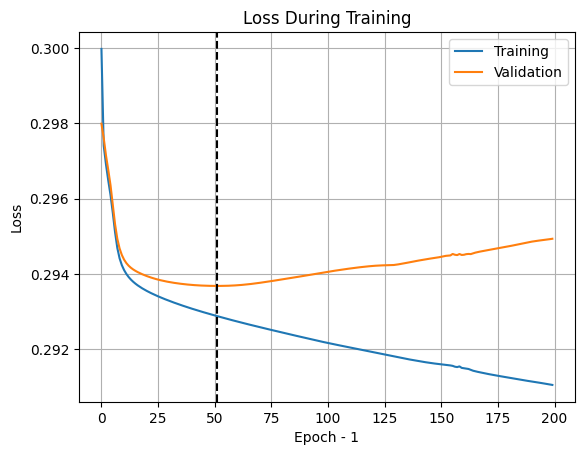

In [10]:
# Plot training history (vertical line at best validation loss)
fig = (
    pd.DataFrame({"loss": history["loss"], "val_loss": history["val_loss"]})
    .rename(columns={"loss": "Training", "val_loss": "Validation"})
    .plot(xlabel="Epoch - 1", ylabel="Loss", title="Loss During Training", grid=True)
)
_ = fig.axvline(np.argmin(history["val_loss"]), color="black", linestyle="--")


## Evaluate Results

In [11]:
# Load best weights and evaluate
model.load_state_dict(torch.load(checkpoint_path))

print(f"Poisson Deviance (Learn): {score(model, X_learn, y_learn, v_learn):.3f}")
print(f"Poisson Deviance (Test): {score(model, X_test, y_test, v_test):.3f}")

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    learn_nn = model(X_learn, v_learn).detach().numpy()

print(f"Balance Property: {mu_hom:.4f} {learn_nn.sum() / learn['Exposure'].sum():.4f}")

Poisson Deviance (Learn): 44.973
Poisson Deviance (Test): 44.928
Balance Property: 0.0736 0.0739


## Balance Property Adjustment

In [12]:
# "Freeze" all parameters of the hidden and embedding layers
[el.weight.requires_grad_(requires_grad=False) for el in model.hidden_layers]
[el.bias.requires_grad_(requires_grad=False) for el in model.hidden_layers]
model.brand_embed.weight.requires_grad_(requires_grad=False)
model.region_embed.weight.requires_grad_(requires_grad=False);

Epoch 10/50, Loss: 0.2927, Val Loss: 0.2937
Epoch 20/50, Loss: 0.2926, Val Loss: 0.2937
Epoch 30/50, Loss: 0.2926, Val Loss: 0.2937
Epoch 40/50, Loss: 0.2926, Val Loss: 0.2937
Epoch 50/50, Loss: 0.2926, Val Loss: 0.2938


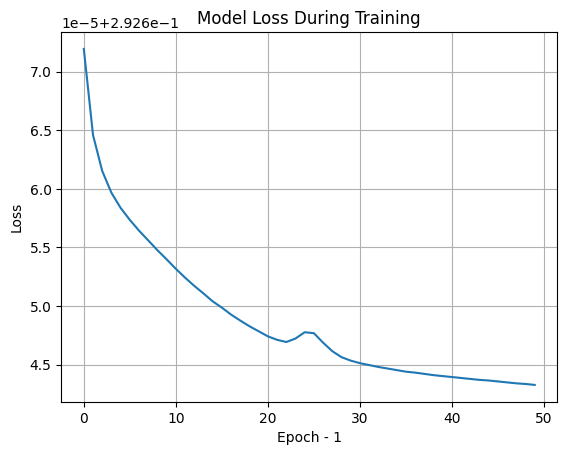

In [13]:
# we don't do batch training anymore, so we set batch_size to the size of the training
# set
batch_size = len(y_train)
optimizer = torch.optim.NAdam(model.parameters(), lr=0.0023)

history = train_model(
    model,
    X_train,
    y_train,
    v_train,
    X_val,
    y_val,
    v_val,
    optimizer,
    checkpoint_path=None,
    batch_size=batch_size,
    n_epochs=50,
)
_ = pd.DataFrame(history["loss"]).plot(
    xlabel="Epoch - 1",
    ylabel="Loss",
    title="Model Loss During Training",
    grid=True,
    legend=False,
    # ylim=(0, 0.2),
)

In [14]:
print(f"Poisson Deviance (Learn): {score(model, X_learn, y_learn, v_learn):.3f}")
print(f"Poisson Deviance (Test): {score(model, X_test, y_test, v_test):.3f}")

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    learn_nn_reg = model(X_learn, v_learn).detach().numpy()

print(
    f"Balance Property: {mu_hom:.4f} {learn_nn_reg.sum() / learn['Exposure'].sum():.4f}"
)

Poisson Deviance (Learn): 44.970
Poisson Deviance (Test): 44.915
Balance Property: 0.0736 0.0736


## Visualize Embeddings

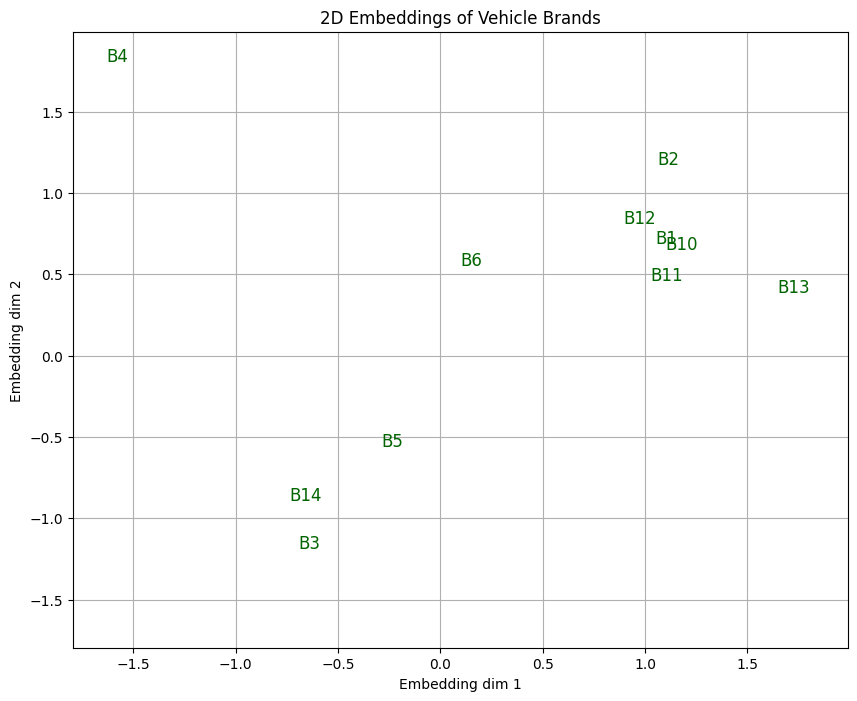

In [15]:
# Embeddings visualization
import matplotlib.pyplot as plt

# Extract embeddings
veh_br = model.brand_embed.weight.detach().numpy()

# Get unique vehicle brands and their indices
vb_names = learn.loc[~learn["VehBrand"].duplicated(), ["VehBrand"]]
vb_names = vb_names.sort_values("VehBrand")

# Calculate plot limits
lim0 = 1.1 * np.array([veh_br.min(), veh_br.max()])

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(veh_br[:, 0], veh_br[:, 1], alpha=0)  # invisible points to set the scale
plt.xlim(lim0)
plt.ylim(lim0)

# Add text labels for each brand
for i, brand in enumerate(vb_names["VehBrand"]):
    plt.annotate(brand, (veh_br[i, 0], veh_br[i, 1]), color="darkgreen", fontsize=12)

plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")
plt.title("2D Embeddings of Vehicle Brands")
plt.grid(True)
plt.show()

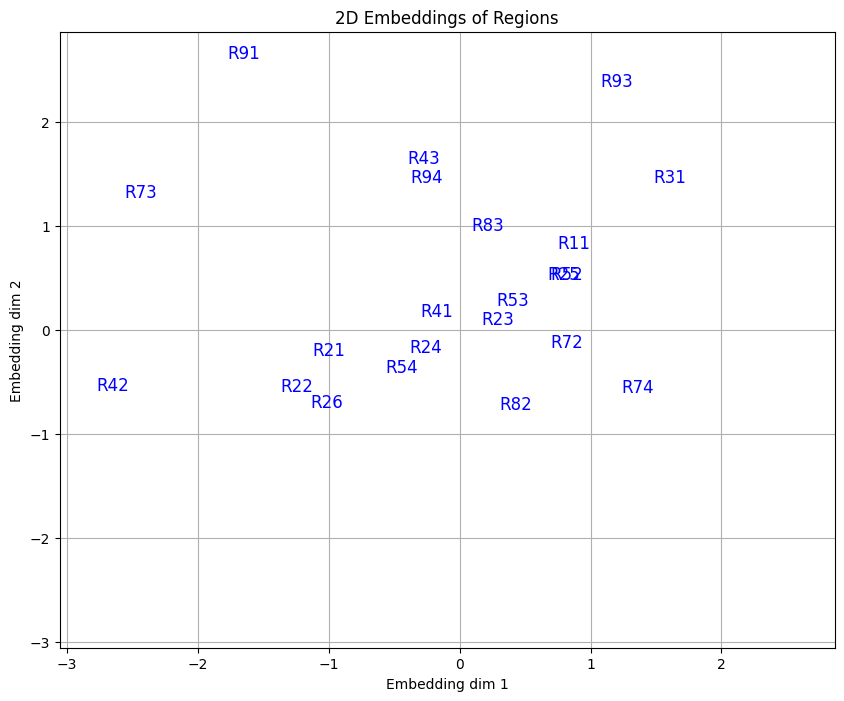

In [16]:
# Extract embeddings for regions
region_br = model.region_embed.weight.detach().numpy()

# Get unique regions and their indices
region_names = learn.loc[~learn["Region"].duplicated(), ["Region"]]
region_names = region_names.sort_values("Region")

# Calculate plot limits
lim0 = 1.1 * np.array([region_br.min(), region_br.max()])

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(
    region_br[:, 0], region_br[:, 1], alpha=0
)  # invisible points to set the scale
plt.xlim(lim0)
plt.ylim(lim0)

# Add text labels for each region
for i, region in enumerate(region_names["Region"]):
    plt.annotate(region, (region_br[i, 0], region_br[i, 1]), color="blue", fontsize=12)

plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")
plt.title("2D Embeddings of Regions")
plt.grid()
plt.show()